# Learning objectives

This is a series of 4 notebooks. By the end, you should able to:
1. Explain the difference between `pretrain`, `finetune`, and `continue pretrain`
2. Understand when and why `pretrain`, `finetune`, and `continue pretrain`
3. Implement `continue pretrain` of a MaskedLM and use the output model for a downstream `finetune` task

- LLM used: RoBERTa-base
- Dataset used: climate change policy dataset
- Machine Learning Libraries: HuggingFace, Tensorflow

Note: The notebook was compiled in Google Colab, with file streaming from Google Drive. To run the notebook in your own environment, change the file path as needed.

In [1]:
PATH = '/content/drive/MyDrive/Projects/Pretrain_MLM_PERMANENT/'

# Concepts

## What is the difference between `pretrain` and `finetune`?



A language model is `pretrained` on a `large` dataset to learn general representations of language. The model is `pretrained` for an `initial task`. For BERT, the initial tasks were fill-mask and next-sentence-prediction.

In contrast, `finetune` refers to the process of taking a `pretrained` model and `repurpose` it for a `different task`, this is generally done with a much `smaller` dataset. For example, we could take BERT and a movie review dataset to `classify` whether the movie reviews are positive or negative (ie, sentiment analysis).

Notice that in this example, BERT was not trained to perform classification, but the model can be `repurposed` to perform the new task (ie, `finetune`). This works well (compared to training a sentiment analysis model using only the movie review dataset from scratch) because the `pretrained` model already learned some general representations of language due to the fact it was trained on a large dataset.

## What is `continue pretraining`?

`Continue pretraining` means we take the `pretrained` model (together with the trained weights) and a new dataset and continue training the model for its `initial task`. For example, we can `continue pretraining` BERT for the initial tasks of fill-mask and next-sentence-prediction.

Notice the difference between `continue pretraining` and `finetuning`. In both cases, we train the `pretrained` model on a new dataset, but when we `continue pretraining`, we continue to train the model for its `initial tasks`, whereas when we `finetune`, the model is `repurposed` to a different task.

## Why `continue pretraining`?



`Continue pretraining` a `pretrained` model could help the model gain a better representation of language within a `specific domain` (ie, Domain-Adaptive Pretraining) or a `specific task` (ie, Task-Adaptive Pretraining). [Support](https://aclanthology.org/2020.acl-main.740.pdf)

For example, BERT was `pretrained` using (mostly) wikipedia texts, so it might not have learned good representations of `domain specific` texts, such as `medical terms`. You might find it beneficial to `continue pretraining` BERT with `domain specific` texts before using on a downstream tasks within that domain to potentially boost the performance.

Another benefit of `continue pretraining` a `self-supervised` model is that the model omits the need for human-annotated labels, which can be expensive and scarce to come by. Imagine you want to train a classifier that uses doctor notes to predict diagnostics, you have lots of doctor notes but only a small portion of them are labelled with diagnosis. If you only use the labelled portion to train your classifier, the majority of your data are essentially wasted. You might then consider using all the doctor notes to `continue pretraining` the model so it gains a better representation of the domain and task of your interest before moving on to building your classification model using the labelled data.

# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import pandas as pd
import numpy as np
import math

# train/val/test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for models
import tensorflow as tf

!pip install transformers -q
import transformers
from transformers import pipeline, TFRobertaModel, TFRobertaForMaskedLM, RobertaTokenizer, DataCollatorForLanguageModeling

!pip install datasets -q
import datasets

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for evaluation metrics
from sklearn.metrics import classification_report

!pip install evaluate -q
from evaluate import load

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


# Load RoBERTa


[RoBERTa](https://arxiv.org/abs/1907.11692) is one of the BERT family models that uses a `masked-language-model` approach as its initial task. The researchers that introduced RoBERTa investigated the design choices made in the original BERT model and identified a few improvement areas that lead to performance gain. Below are a few key areas where RoBERTa differs from BERT:

1. Unlike BERT, where masking was performed only once during data preprocessing (training data was duplicated 10 times so that each sequence is masked in 10 different ways over the 40 epochs of training, resulting in each training sequence was seen with the same mask four times during training) resulting in a single static mask (`static masking`), RoBERT employed `dynamic masking` where different masking pattern was generated every time a sequence was feed to the model.
2. Unlike BERT, where the initial training tasks consisted of fill-mask and next-sentence-prediction, RoBERTa removed the next-sentence-prediction task from its initial tasks and focused only on the fill-mask task.
3. Further, unlike BERT, where short sequences were randomly injected and the sequence length for the first 90% of updates were reduced, RoBERTa was trained only with full-length sequences (T = 512 tokens), and RoBERTa used a larger byte-level Byte-Pair Encoding vocabulary as well as larger batch sizes in its training.
4. RoBERTa was also trained on a different dataset than BERT, but the dataset matches the overall quantity and quality of the dataset used for BERT.

- [GitHub](https://github.com/facebookresearch/fairseq/tree/main/examples/roberta)
- [HuggingFace](https://huggingface.co/docs/transformers/model_doc/roberta)

Keeping in mind that `RoBERTa` was trained using `Byte-Pair Encoding` tokenizers with casing and `base` has 12 layers while `large` has 24. For the showcase here, we will use `roberta-base`, but the same techniques can be easily adopted to roberta-large.

In [3]:
CHECKPOINT = 'roberta-base'
TOKENIZER = RobertaTokenizer.from_pretrained(CHECKPOINT)
ROBERTA_MODEL = TFRobertaModel.from_pretrained(CHECKPOINT)
ROBERTA_MLM = TFRobertaForMaskedLM.from_pretrained(CHECKPOINT)

# per RoBERTa default
MAX_LEN = 512
VOCAB_SIZE = 50265
HIDDEN_DIM = 768

BATCH_SIZE = 8
LR_SCHEDULE = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-2,
                                                            decay_steps=5336,
                                                            end_learning_rate=1e-3,
                                                            power=1.0)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE,
                                      beta_1=0.9,
                                      beta_2=0.98,
                                      epsilon=1e-06,
                                      clipnorm=0.0)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

# Define reusable functions

In [4]:
def to_tokenize(input):
  return TOKENIZER(input,
                   add_special_tokens=True,
                   max_length=MAX_LEN,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf"
                   )

In [5]:
def show_results(model, feature, label, classes):
  yhat_val = model.predict(feature)
  yhat_val_result = np.argmax(yhat_val, axis=-1)

  print('Validation classification Report \n')
  print(classification_report(label, yhat_val_result, target_names=classes))

  ax = sns.heatmap(tf.math.confusion_matrix(label, yhat_val_result),
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 yticklabels=classes,
                 xticklabels=classes,
                 cbar=False)

  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.title('Validation Confusion Matrix')
  plt.show()

# Load Dataset

The dataset is sourced from the [climate policy database](https://climatepolicydatabase.org/). The database is updated periodically to include climate policies adopted from different countries around the globe.

The dataset used in this notebook is the 2023 version downloaded on 1/22/2024. The documentation can be found [here](https://climatepolicydatabase.org/sites/default/files/2023-05/CPDB%20Codebook%20v1.2.pdf).

This dataset is not one of the 'classic' datasets commonly used in learning NLP, rather it is a real-life dataset currated by climate change professionals. As we work through the dataset and the models, you will also identify and recognize some of the painpoints (eg, data quality and model performance) in building machine learning models in real-life.

In [6]:
df = pd.read_csv(f'{PATH}climate_policy_database_policies_export.csv')

df.head()

,policy_id,country_iso,country_update,policy_name,policy_title,jurisdiction,supranational_region,country,subnational_region,policy_city_or_local,...,end_date,high_impact,policy_objective,reference,last_update,impact_indicators.comments,impact_indicators.name,impact_indicators.value,impact_indicators.base_year,impact_indicators.target_year
0,211001480,FRA,Sporadic,Incandescent Lamp Phase-out France (2008),Incandescent Lamp Phase-out,Country,NaN,France,NaN,NaN,...,NaN,Unknown,"Mitigation, Energy access",http://www.developpement-durable.gouv.fr/artic...,NaN,NaN,NaN,NaN,NaN,NaN
1,211001564,IDN,Annual,Jakarta Regulation No. 38/12 on Green Building...,Jakarta Regulation No. 38/12 on Green Buildings,City,NaN,Indonesia,Jakarta,NaN,...,NaN,Unknown,Mitigation,https://www.iea.org/policies/2523-jakarta-regu...,NaN,NaN,NaN,NaN,NaN,NaN
2,211002621,AUS,Annual,Safeguarding the Future: Australia (1998),Safeguarding the Future:,Country,NaN,Australia,NaN,NaN,...,2007.0,Unknown,Mitigation,http://www.climatechange.gov.au,NaN,NaN,NaN,NaN,NaN,NaN
3,211004420,BRB,Sporadic,National Climate Change Policy Barbados (2012),National Climate Change Policy,Country,NaN,Barbados,NaN,NaN,...,NaN,Unknown,"Mitigation, Adaptation",http://gisbarbados.gov.bb/blog/barbados-nation...,NaN,NaN,NaN,NaN,NaN,NaN
4,211004934,BGR,Sporadic,Spatial Planning Act Bulgaria (2001),Spatial Planning Act,Country,NaN,Bulgaria,NaN,NaN,...,NaN,NaN,Mitigation,https://www.mrrb.bg/en/spatial-development-act...,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['policy_id', 'country_iso', 'country_update', 'policy_name',
       'policy_title', 'jurisdiction', 'supranational_region', 'country',
       'subnational_region', 'policy_city_or_local', 'policy_instrument',
       'sector', 'policy_description', 'policy_type', 'stringency',
       'policy_status', 'decision_date', 'start_date', 'end_date',
       'high_impact', 'policy_objective', 'reference', 'last_update',
       'impact_indicators.comments', 'impact_indicators.name',
       'impact_indicators.value', 'impact_indicators.base_year',
       'impact_indicators.target_year'],
      dtype='object')

# Identify modeling objectives:
Our modeling objective is to create a `classification` model by using policy_description to predict policy_type.

Each of the 4 notebooks implement one of the models below:
1. Train a FFNN from scratch
2. Finetune a pretrained LLM (RoBERTa-base)
3. Continue pretraining the pretrained LLM (RoBERTa-base)
4. Finetune the continue pretrained LLM (RoBERTa-base)

This notebook showcase the implementation of baseline:
1. Train a FFNN from scratch

# Prepare dataset

Remove columns not used for the task

In [8]:
cols = ['policy_description', 'policy_type']
df = df[cols]

df.head()

,policy_description,policy_type
0,NaN,Energy efficiency
1,"The policy focuses on energy efficiency, water...",Energy efficiency
2,NaN,Renewables
3,The primary goal of the policy is to establish...,Energy service demand reduction and resource e...
4,Legislative,Non-energy use


For this showcase, I will simply drop instances with missing values. Think about how else you might go about working with datasets that have lots of missing values?

In [9]:
df = df.dropna()
len(df)

4241

Remove any duplicate instances with the same policy_description. Think about why there are so many duplicate instances and how to better utilize datastes that have lots of duplicate data?

In [10]:
df = df.drop_duplicates(subset=['policy_description'],keep='first')
len(df)

3591

Let's also take a look at the label for potential cleaning.

In [11]:
df['policy_type'].value_counts()

,count
policy_type,
Renewables,691
Energy efficiency,595
Other low-carbon technologies and fuel switch,293
"Energy efficiency, Energy service demand reduction and resource efficiency, Non-energy use, Other low-carbon technologies and fuel switch, Renewables",290
"Energy service demand reduction and resource efficiency, Energy efficiency, Renewables, Other low-carbon technologies and fuel switch, Non-energy use",285
...,...
"Renewables, Unknown",1
"Energy efficiency, Renewables, Energy service demand reduction and resource efficiency, Other low-carbon technologies and fuel switch, Non-energy use",1
"Energy efficiency, Energy service demand reduction and resource efficiency, Renewables, Other low-carbon technologies and fuel switch, Non-energy use",1


Based on the documentation 3.14 Mitigation area (policy type), we see that this field is single or multiple choices from their policy matrix.

For this exercise, if there are multiple types, I will treat them as a new class 'Multi'. Think about how else might you tackle the label cleaning.

Since Pandas dataframe is a pretty heavy object, even though operations can be applied to Pandas dataframe using the apply() method, it's often more efficient to operate on NumPy objects or List objects.

In [12]:
policy_types = []

for policy_type in df['policy_type']:
  if len(policy_type.split(',')) > 1:
    policy_types.append('Multi')
  else:
    policy_types.append(policy_type)

assert len(policy_types) == len(df)
df['policy_type'] = policy_types

df['policy_type'].value_counts()

,count
policy_type,
Multi,1578
Renewables,691
Energy efficiency,595
Other low-carbon technologies and fuel switch,293
Non-energy use,267
Energy service demand reduction and resource efficiency,131
Unknown,36


# Train/val/test split

Now that the data is ready, let's split to train/validation/test to prepare for building the model. Once the test set is split out, we want to make sure we do not touch the test set at all to avoid any data leakage.

In [13]:
X = df['policy_description'].to_list()
y = df['policy_type'].to_list()

Since the model expects classes in numeric values, we will encode the classes first

In [14]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

classes = list(label_encoder.inverse_transform(range(df['policy_type'].nunique())))
classes

[np.str_('Energy efficiency'),
 np.str_('Energy service demand reduction and resource efficiency'),
 np.str_('Multi'),
 np.str_('Non-energy use'),
 np.str_('Other low-carbon technologies and fuel switch'),
 np.str_('Renewables'),
 np.str_('Unknown')]

We'll assign 30% of the total data to test, and split the remaining 70% data between train and validation at 80/20 split.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

In [16]:
print('--- training set ---')
print('number of samples: ', len(X_train))
print('examples of features: ', X_train[:5])
print('examples of labels: ', y_train[:5])

print('--- validation set ---')
print('number of samples: ', len(X_val))
print('examples of features: ', X_val[:5])
print('examples of labels: ', y_val[:5])

print('--- test set ---')
print('number of samples: ', len(X_test))
print('examples of features: ', X_test[:5])
print('examples of labels: ', y_test[:5])

--- training set ---
number of samples:  2010
examples of features:  ['The Hawaii Energy Code (HEC) adopted the 2015 IECC and ASHRAE 90.1-2013 with amendments by the State Building Council on July 14, 2015. The HEC must be adopted separately by the four counties. State law (Act 164, 2014), requires that if the counties do not adopt HEC by 2017, the HEC becomes the interim code for the counties. (For details, see reference below.) IEA/IRENA Global Renewable Energy Policies and Measures Database © OECD/IEA and IRENA, [November 2020]', 'The Small Power Producers (SPP) framework created an enabling environment for private project developments of projects up to 10MW in 2008, through standardised power purchase agreements. (For details, see reference below.)', 'The Action Plan for Renewable Energy Promotion in Mali was established to achieve the renewable energy target of increasing the share of renewables in TPES from less than 1% in 2002 to 15% in 2020. The energy policy is defined by 5 ma

# Tokenize the feature using RoBERTa tokenizer

In [17]:
X_train_tokenized = to_tokenize(X_train)
X_val_tokenized = to_tokenize(X_val)
X_test_tokenized = to_tokenize(X_test)

# Model 1. Train a FFNN from scratch

In [18]:
def build_baseline(hidden_size=[1024]):

  tf.keras.backend.clear_session()

  input = tf.keras.layers.Input(shape=(MAX_LEN,))

  embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=MAX_LEN)(input)

  hidden = tf.math.reduce_mean(embedding, axis=1)

  for i, each in enumerate(hidden_size):
    hidden= tf.keras.layers.Dense(each, activation='relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.1)(hidden)

  outputs = tf.keras.layers.Dense(units=len(classes), activation='softmax')(hidden)

  model = tf.keras.Model(inputs=input, outputs=outputs)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=OPTIMIZER,
                metrics=['accuracy'])

  return model

In [19]:
baseline = build_baseline()

baseline_history = baseline.fit(x=X_train_tokenized.input_ids,
                                y=y_train,
                                epochs=3,
                                batch_size=BATCH_SIZE,
                                validation_data=(X_val_tokenized.input_ids, y_val),
                                verbose=1
                                )

Epoch 1/3
252/252 [==============================] - 220s 870ms/step - loss: 1.5166 - accuracy: 0.4552 - val_loss: 1.2852 - val_accuracy: 0.5765
Epoch 2/3
252/252 [==============================] - 209s 832ms/step - loss: 1.1150 - accuracy: 0.6204 - val_loss: 1.2679 - val_accuracy: 0.6123
Epoch 3/3
252/252 [==============================] - 209s 829ms/step - loss: 0.7646 - accuracy: 0.7448 - val_loss: 1.3564 - val_accuracy: 0.6501


I trained for only 3 epochs, the model is quite overfitted and the validation accuracy is meh. Let's take a look at the classification report.

16/16 [==============================] - 1s 37ms/step
Validation classification Report 

                                                         precision    recall  f1-score   support

                                      Energy efficiency       0.75      0.64      0.69        86
Energy service demand reduction and resource efficiency       0.00      0.00      0.00        17
                                                  Multi       0.76      0.69      0.72       232
                                         Non-energy use       0.24      0.35      0.29        31
          Other low-carbon technologies and fuel switch       0.71      0.43      0.54        35
                                             Renewables       0.57      0.87      0.69        98
                                                Unknown       0.00      0.00      0.00         4

                                               accuracy                           0.65       503
                                    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


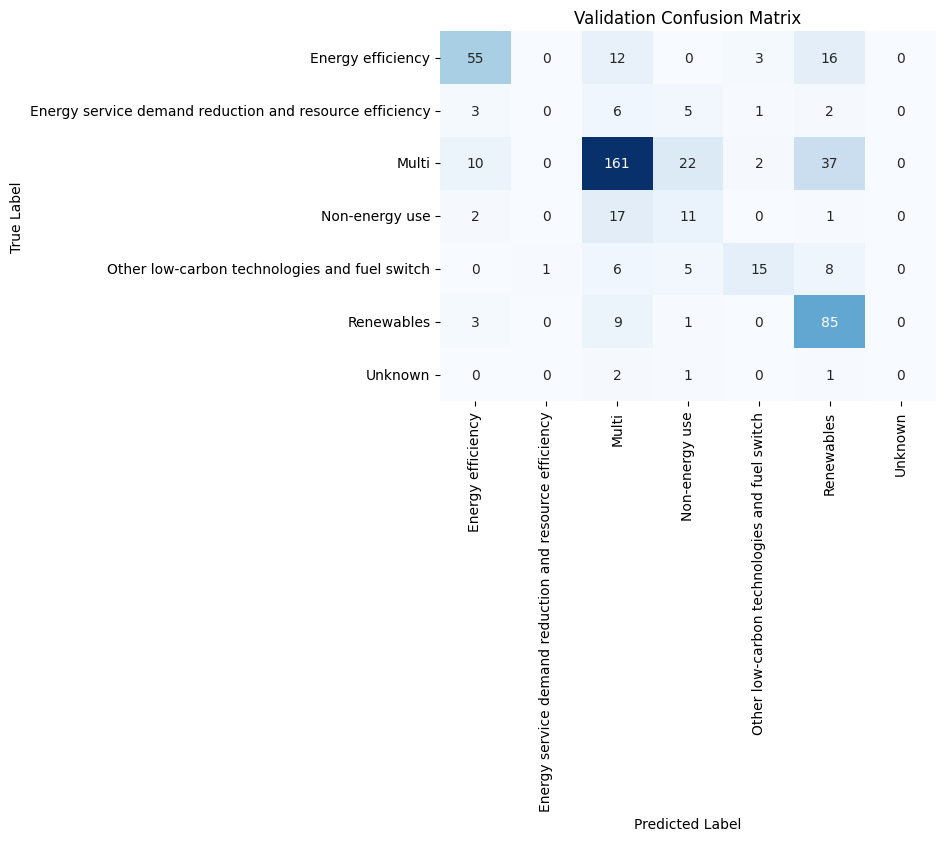

In [20]:
show_results(baseline,
             X_val_tokenized.input_ids,
             y_val,
             classes)

# Review result and run inference

Let's review the validation accuracy from the model

In [21]:
print('----- FFNN model trained from scratch -----')
print(baseline_history.history['val_accuracy'][-1])

----- FFNN model trained from scratch -----
0.6500993967056274


Let's then run inference on the trained model

In [22]:
print('----- FFNN model trained from scratch -----')
print(baseline.evaluate(X_test_tokenized.input_ids, y_test))

----- FFNN model trained from scratch -----
34/34 [==============================] - 1s 36ms/step - loss: 1.1856 - accuracy: 0.6512
[1.1855615377426147, 0.6512059569358826]
